In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dsmc_core import DSMC_Core

In [2]:
sim = DSMC_Core()
sim.wp.Omega = 1e-4
sim.wp.T0 = 1e-5
sim.wp.Nx = 15
sim.wp.Ny = 15
sim.wp.Nz = 15

sim.pp.eps = 0.3

sim.initialize()
print(sim)


        -------------------------------------------------------------------------
                                  World Parameters
        -------------------------------------------------------------------------
                   Number of particles:          N = 100_000
                        Number density:          n = 0.500 1/m^3
                Simulation area volume:          V = 200_000.000 m^3
                       Number of boxes: Nx, Ny, Nz = (15, 15, 15)
          Simulation area linear sizes: Lx, Ly, Lz = (58.480, 58.480, 58.480) m
             Volume of the cubical box:      V_box = 59.259 m^3
                Linear size of the box:      L_box = 3.899 m
                         Orbital speed:      Omega = 0.00010 1/s
        -------------------------------------------------------------------------
                                  Particle Parameters
        -------------------------------------------------------------------------
                                Rad

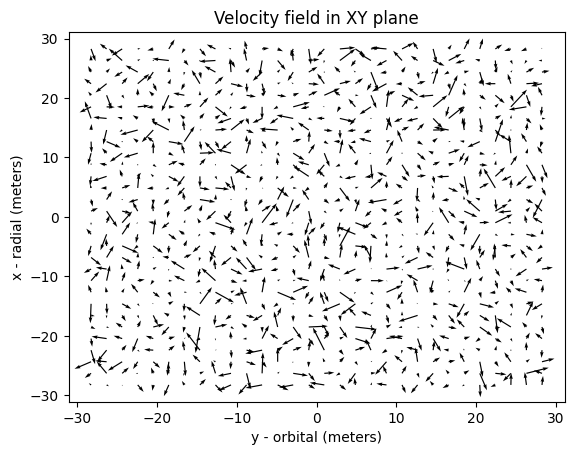

In [3]:
x,y,u,v = sim.plane_velocity_field(2*sim.wp.Nx, 2*sim.wp.Ny)
fig, ax1 = plt.subplots()
ax1.set_title("Velocity field in XY plane")
ax1.set_ylabel("x - radial (meters)")
ax1.set_xlabel("y - orbital (meters)")
Q = ax1.quiver(y,x,v,u, units='width')
fig.savefig('xy-velocity_distribution_t=0.jpg')

<BarContainer object of 50 artists>

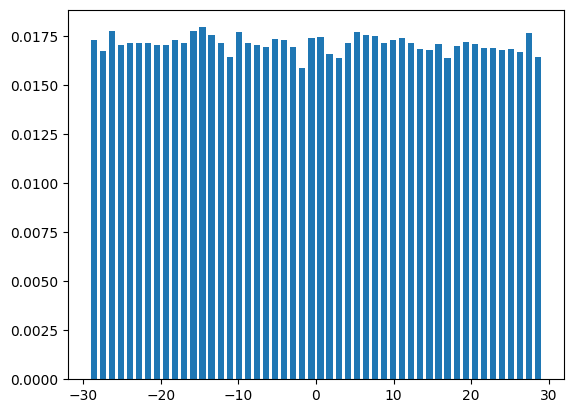

In [4]:
hist, bins = sim.vertical_view(50)
plt.bar(bins, hist)

In [5]:
vth_x, vth_y, vth_z = sim.thermal_speeds_ellipsoid()
print(vth_x, vth_y, vth_z)

0.004602361415346042 0.0052533396258500715 0.004601416950102561


In [6]:
time_array = np.asarray([sim.t])
temp_array = np.asarray([sim.T0])
calt_array = np.asarray([sim.calibrated_temperature])
ncol_array = np.asarray([sim.nc])

cx, cy, cz = sim.thermal_speeds_ellipsoid()
cx_array = np.asarray([cx])
cy_array = np.asarray([cy])
cz_array = np.asarray([cz])

hist_array = [hist]
T = 2*np.pi/sim.wp.Omega
sim_end = 6*T
cyclic_time = sim.t

print(T, sim.t)
while sim.t < sim_end:
    sim.make_step()
    time_array = np.append(time_array, sim.t)
    temp_array = np.append(temp_array, sim.temperature)
    calt_array = np.append(calt_array, sim.calibrated_temperature)
    ncol_array = np.append(ncol_array, sim.nc)
    vth_x, vth_y, vth_z = sim.thermal_speeds_ellipsoid()
    cx_array = np.append(cx_array, vth_x)
    cy_array = np.append(cy_array, vth_y)
    cz_array = np.append(cz_array, vth_z)
    cyclic_time += sim.dt
    if cyclic_time > T/4:
        cyclic_time = 0.0
        hist, _ = sim.vertical_view(50)
        hist_array.append(hist)

    print(f" Simulating: {100*sim.t/sim_end:3.2f}%, time: {sim.t:.3f}, dt: {sim.dt:.3f}, cyclic time: {cyclic_time:.3f}, temperature: {sim.temperature:.3f}, calibrated temperature: {sim.calibrated_temperature:.3f}, total collisions: {sim.nc}", end="\r", flush=True)
print("")
print("Finished simulation")

62831.85307179586 0.0
 Simulating: 100.09%, time: 377329.509, dt: 359.667, cyclic time: 12927.481, temperature: 0.000, calibrated temperature: 0.000, total collisions: 1271778
Finished simulation


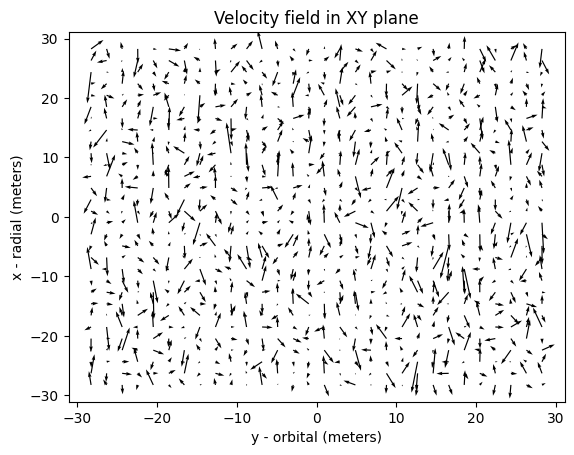

In [7]:
x,y,u,v = sim.plane_velocity_field_reduced(2*sim.wp.Nx, 2*sim.wp.Ny)
fig, ax1 = plt.subplots()
ax1.set_title("Velocity field in XY plane")
ax1.set_ylabel("x - radial (meters)")
ax1.set_xlabel("y - orbital (meters)")
Q = ax1.quiver(y,x,v,u, units='width')
fig.savefig("xy-velocity_distribution_t=end.jpg")

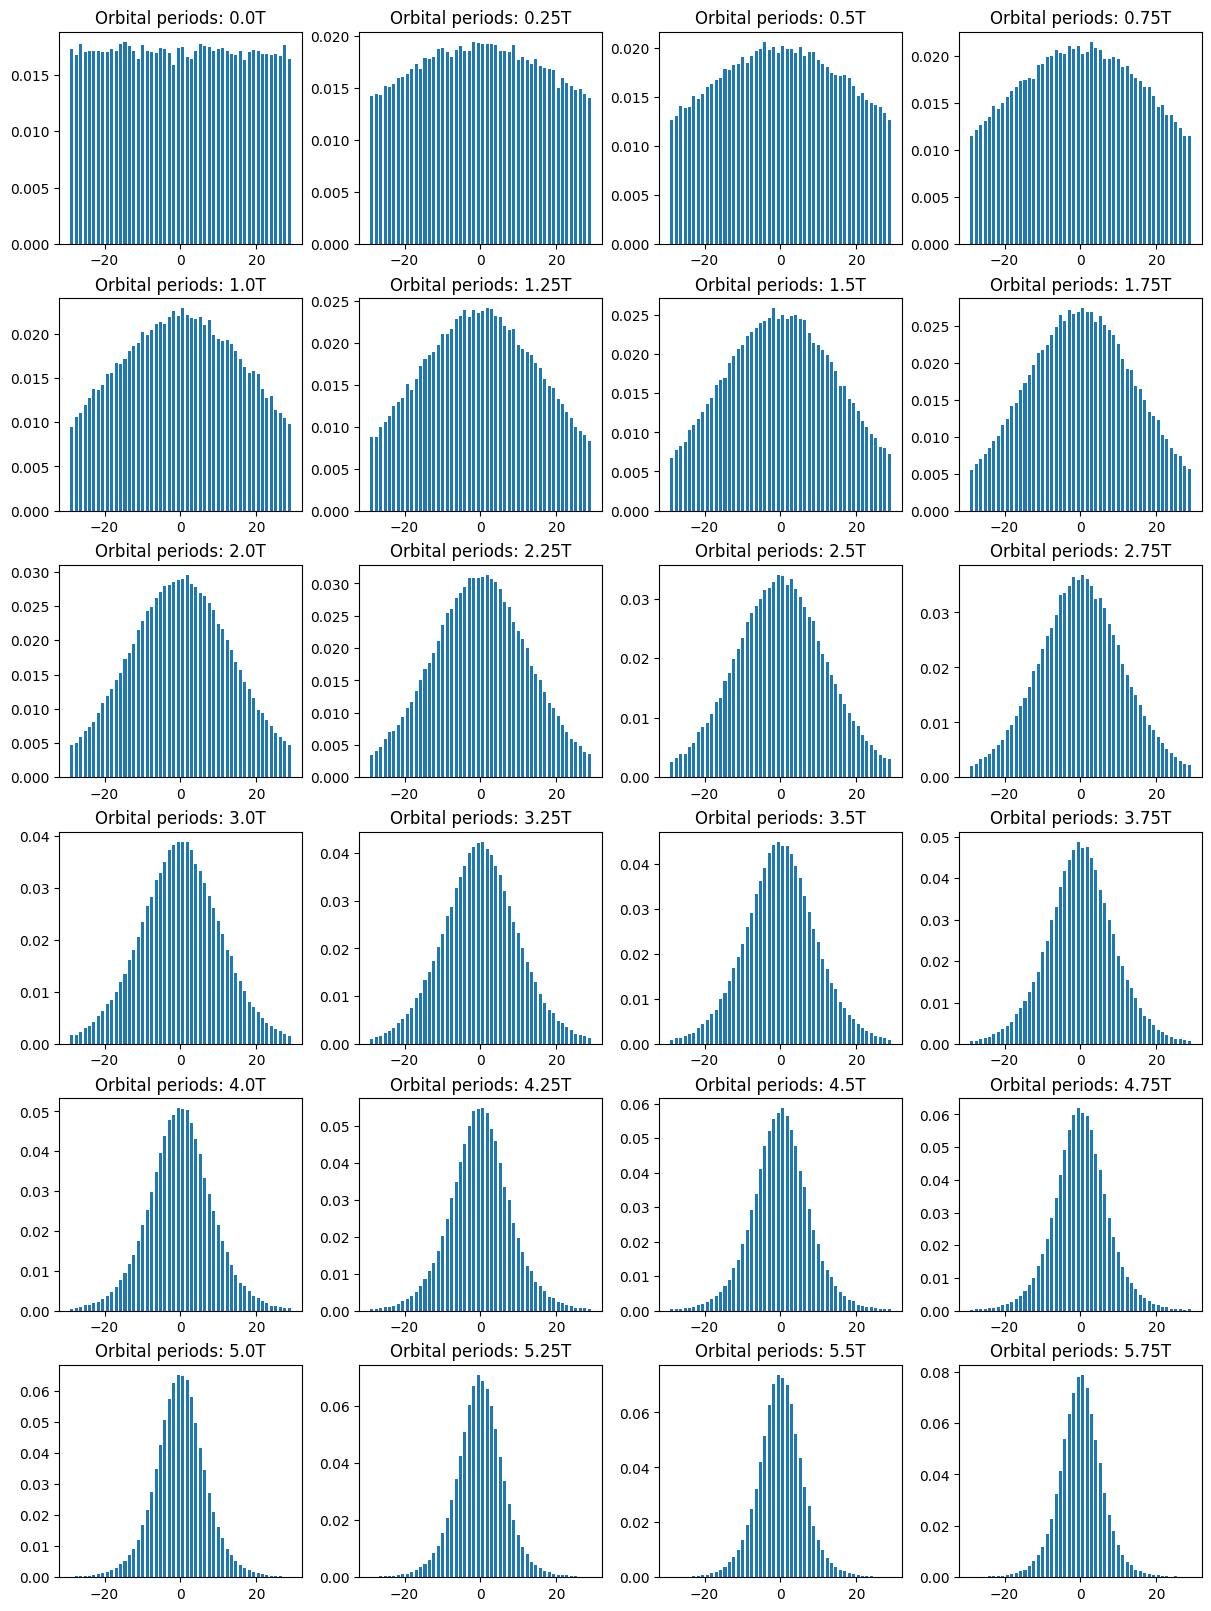

In [8]:
fig, axs = plt.subplots(6,4, figsize=(12,16), layout='constrained')
p = 0
for ax in axs.flat:    
    ax.set_title(f'Orbital periods: {p/4}T')   
    ax.bar(bins, hist_array[p])
    p += 1
fig.savefig("vertical_number_density_distribution.jpg")

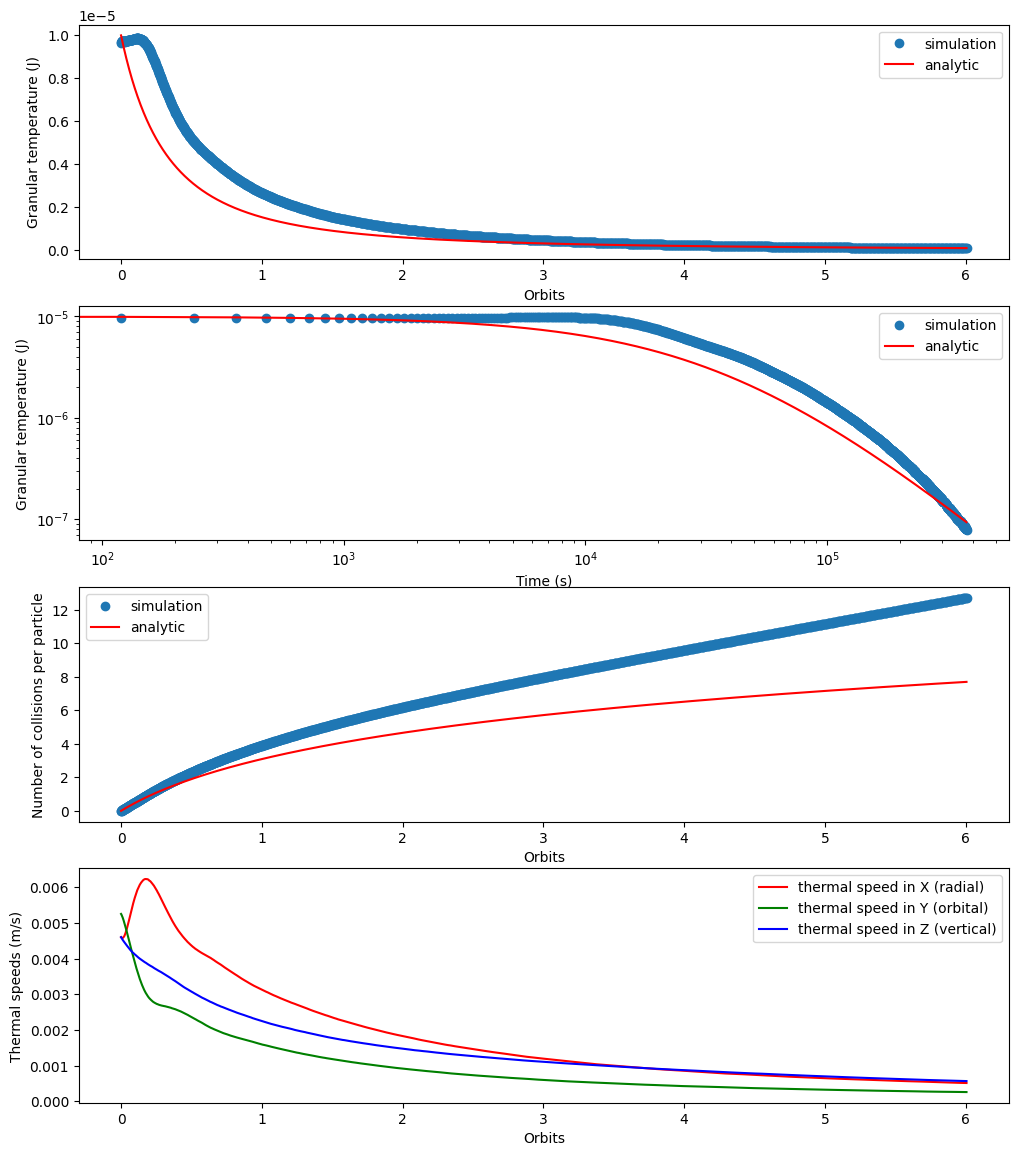

In [25]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1)
fig.set_figheight(14)
fig.set_figwidth(12)


ax0.plot(time_array/T, calt_array, "o", label="simulation")
ax0.plot(time_array/T, sim.haff_cooling(time_array), label="analytic", color="red")
ax0.set_xlabel("Orbits")
ax0.set_ylabel("Granular temperature (J)")
ax0.legend()

#ax1.plot(time_array, temp_array, "o", label="simulation")
ax1.plot(time_array, calt_array, "o", label="simulation")
ax1.plot(time_array, sim.haff_cooling(time_array), label="analytic", color="red")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Granular temperature (J)")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.legend()

ax2.plot(time_array/T, ncol_array / sim.wp.N, "o", label="simulation")
ax2.plot(
    time_array/T,
    sim.ncol_analytic(time_array) / sim.wp.N,
    label="analytic",
    color="red",
)
ax2.set_xlabel("Orbits")
ax2.set_ylabel("Number of collisions per particle")
ax2.legend()

ax3.plot(time_array/T, cx_array, "red", label="thermal speed in X (radial)")
ax3.plot(time_array/T, cy_array, "green", label="thermal speed in Y (orbital)")
ax3.plot(time_array/T, cz_array, "blue", label="thermal speed in Z (vertical)")
ax3.set_xlabel("Orbits")
ax3.set_ylabel("Thermal speeds (m/s)")
ax3.legend()

fig.savefig("Sheared_evolution.jpg")

In [10]:
nx, ny = 5*sim.wp.Nx, 5*sim.wp.Ny
u_grid = np.zeros((nx,ny), dtype=np.float64)
v_grid = np.zeros((nx,ny), dtype=np.float64)
x_grid, y_grid = np.meshgrid(np.linspace(-sim.wp.Lx/2, sim.wp.Lx/2, nx), np.linspace(-sim.wp.Ly/2, sim.wp.Ly/2, ny))
x_grid = x_grid.T
y_grid = y_grid.T

for i in range(sim.wp.N):
    ix = int(nx*(sim.rx[i]-sim.wp.Lx/2)/sim.wp.Lx)
    iy = int(ny*(sim.ry[i]-sim.wp.Ly/2)/sim.wp.Ly)
    u_grid[ix,iy] += sim.vx[i]
    v_grid[ix,iy] += sim.vy[i]

u_grid /= sim.wp.N
v_grid /= sim.wp.N

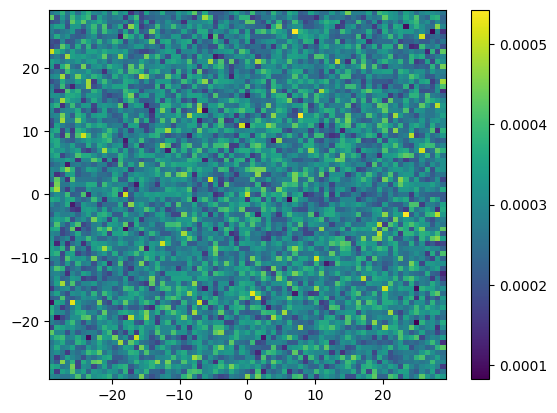

In [11]:
plt.hist2d(sim.rx, sim.ry, bins=(nx,ny), density=True)
plt.colorbar()

In [12]:
def normal_distribution(x, sigma):
    return (1/(sigma*np.sqrt(2*np.pi))*np.exp(-x**2/(2*sigma**2)))

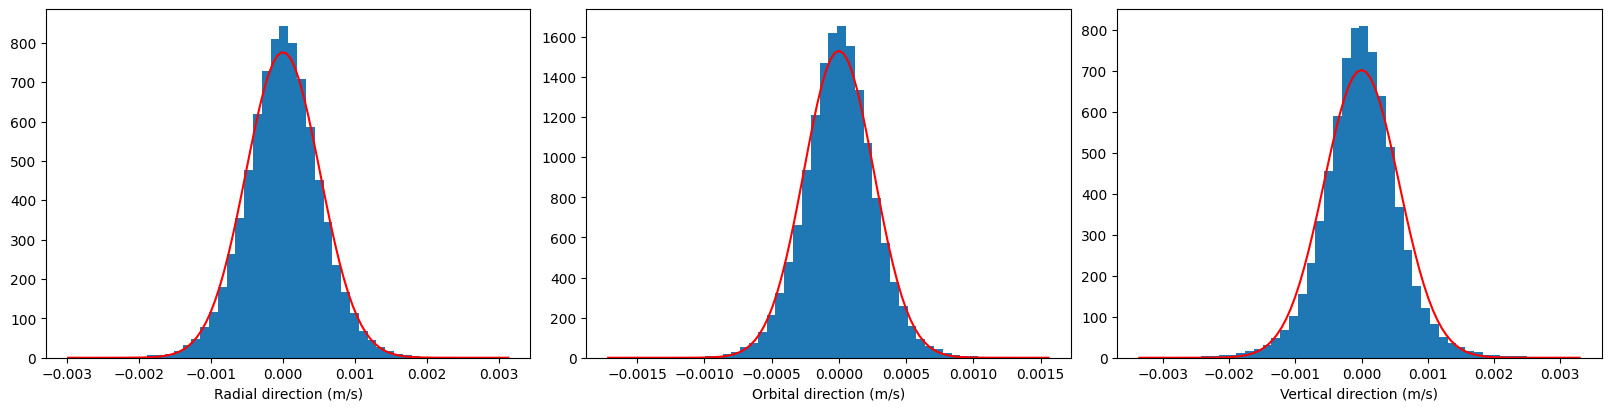

In [27]:
vth_x, vth_y, vth_z = sim.thermal_speeds_ellipsoid()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4), layout="constrained")

ax1.hist(sim.vx, bins=50, density=True)
vx_array = np.linspace(sim.vx.min(), sim.vx.max(), 100)
ax1.set_xlabel("Radial direction (m/s)")
ax1.plot(vx_array, normal_distribution(vx_array, vth_x), color='red')

cy = sim.vy + 3*sim.rx*sim.wp.Omega/2
ax2.hist(cy, bins=50, density=True)
vy_array = np.linspace(cy.min(), cy.max(), 100)
ax2.set_xlabel("Orbital direction (m/s)")
ax2.plot(vy_array, normal_distribution(vy_array, vth_y), color='red')

ax3.hist(sim.vz, bins=50, density=True)
vz_array = np.linspace(sim.vz.min(), sim.vz.max(), 100)
ax3.plot(vz_array, normal_distribution(vz_array, vth_z), color='red')
ax3.set_xlabel("Vertical direction (m/s)")
fig.savefig("speed_distributions.jpg")

In [16]:
vth_x

0.0005139414966985982